# Integrating scRNA-seq data with PPI networks to study cell type-specific expression patterns in Alzheimer

This study aims toanalyze differentially expressed genes (DEGs), integrate the expression values in the PPI network and evaluate how gene expression patterns vary across cell types in Alzheimer.

In [2]:
import scanpy as sc
import sys
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from pandas.plotting import table
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import norm
from matplotlib.patches import Rectangle
import glob

sys.path.append('functions/')
import functions

ModuleNotFoundError: No module named 'scanpy'

## 1.  Load data

The original dataset includes cells from multiple conditions (Normal, Alzheimer's, FTD, PSP). For this analysis, we are only interested in comparing Normal vs Alzheimer's, so these two conditions are filtered out.

These dataset comes from CellXGene platform, and its available at: https://cellxgene.cziscience.com/collections/c53573b2-eff4-4c5e-9ad0-b24d422dfd9b

In [2]:
adata = sc.read_h5ad('../data/cross-dementia.h5ad')

KeyboardInterrupt: 

In [ ]:
# Filter by Normal y Alzheimer
adata = adata[adata.obs['disease'].isin(['normal', 'Alzheimer disease'])]

In [1]:
print("\n✅ Observations summary:")
print(f"Total number of cells: {adata.n_obs}")
print(f"Total number of cellular types: {adata.obs['cell_type'].nunique()}")
print(f"Total number of unique tissues: {adata.obs['tissue'].nunique()}")
print(f"Total number of states: {adata.obs['disease'].nunique()}")

print("\n✅ Variables summary:")
print(f"Total number of genes: {adata.n_vars}")
print(f"Number of highly variable genes: {adata.var['vst.variable'].sum()}")


✅ Observations summary:


NameError: name 'adata' is not defined

## 2. Data preprocessing

### 2.1. Filter genes

Filter genes expressed in a minimum of 10 cells and filter cells which do not express at least 200 genes. These genes are often technical noise or of little biological relevance in the context of interest.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)

In [ ]:
print(f"Total number of cells after filtering: {adata.n_obs}")

In [ ]:
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
print(f"Total number of genes after filtering: {adata.n_vars}")

### 2.2. Normalization and log transformation

**Normalization** is performed because the raw RNA-seq counts depend on the sequencing depth. Therefore, the sum of counts per cell is normalised to a constant value (10,000). This allows comparison between cells with different sequencing depths.

In addition, **log-transformation (log1p)** is applied to stabilise the variance and reduce the impact of genes with extreme high abundance.

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
sc.pp.log1p(adata)

In [13]:
adata.write('../data/preprocessed_data.h5ad')

## 2.3. Dataset division



In [3]:
adata = sc.read_h5ad('../data/preprocessed_data.h5ad')

In [4]:
print(adata.obs['cell_type'].value_counts())
print(adata.obs['disease'].value_counts())

cell_type
oligodendrocyte                      76181
glutamatergic neuron                 60845
astrocyte                            32390
inhibitory interneuron               18662
oligodendrocyte precursor cell       14054
microglial cell                      10818
endothelial cell of vascular tree     3017
pericyte                               925
T cell                                 136
Name: count, dtype: int64
disease
Alzheimer disease    118234
normal                98794
Name: count, dtype: int64


In [5]:
cell_types = adata.obs['cell_type'].unique()

# Create a dictionary to save the data for each cell type
data_per_type = {}
for type in tqdm(cell_types, desc="Procesing cell types"):
    data_per_type[type] = adata[adata.obs['cell_type'] == type].copy()

Procesing cell types: 100%|██████████| 9/9 [03:05<00:00, 20.61s/it]


In [6]:
data_per_type

{'astrocyte': AnnData object with n_obs × n_vars = 32390 × 28215
     obs: 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'ct_subcluster', 'library_id', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
     uns: 'citation', 'log1p', 'schema_reference', 'schema_version', 'title'
     obsm: 'X_pca', 'X_tsne', 'X_umap',
 'glutamatergic neuron': AnnData object with n_obs × n_vars = 60845 × 28215
     obs: 'organi

## 3. Differential expression analysis

Scanpy, when running sc.tl.rank_genes_groups(), automatically prioritises adata.raw if it exists. In this case, we saved the raw array in adata.raw to begin with (which is correct), but Scanpy is using that raw array instead of the normalised, log-transformed .X array.

Files **degs_{cell_type}_total.csv** stores all differentially expressed genes found per each cell type, identified by the ENSEMBL ID.

In [7]:
for type, adata_type in tqdm(data_per_type.items(), desc= 'Analyzing cell types...'):

    adata_normal = adata_type[adata_type.obs['disease'] == 'normal'].copy()
    adata_disease = adata_type[adata_type.obs['disease'] == 'Alzheimer disease'].copy()

    # IMPORTANT: forge use of log normalize X data.
    adata_type.raw = None

    # Differential expression analysis with wilcoxon, using the normal expression as baseline
    sc.tl.rank_genes_groups(adata_type, groupby='disease', method='wilcoxon', reference='normal')

    # Extract results of DEGs for "disease"" condition (compared to normal)
    degs_disease = sc.get.rank_genes_groups_df(adata_type, group='Alzheimer disease')

    # Filter by logFC y p-adj
    degs_disease_filtered = degs_disease[
        (degs_disease['logfoldchanges'].abs() >= 0.25) &
        (degs_disease['pvals_adj'] <= 0.05)
    ]

    print(f'{len(degs_disease_filtered)} DEGs found for {type} for Alzheimer disease')

    degs_disease_filtered.to_csv(f'../data/complete/degs_{type}_total.csv', index=False)

Analyzing cell types...:  11%|█         | 1/9 [02:11<17:30, 131.28s/it]

3712 DEGs found for astrocyte for Alzheimer disease


Analyzing cell types...:  22%|██▏       | 2/9 [08:22<31:45, 272.28s/it]

5467 DEGs found for glutamatergic neuron for Alzheimer disease


Analyzing cell types...:  33%|███▎      | 3/9 [09:01<16:35, 165.95s/it]

2193 DEGs found for oligodendrocyte precursor cell for Alzheimer disease


Analyzing cell types...:  44%|████▍     | 4/9 [16:45<23:37, 283.57s/it]

4002 DEGs found for oligodendrocyte for Alzheimer disease


Analyzing cell types...:  56%|█████▌    | 5/9 [17:48<13:36, 204.07s/it]

4878 DEGs found for inhibitory interneuron for Alzheimer disease


Analyzing cell types...:  67%|██████▋   | 6/9 [18:16<07:12, 144.03s/it]

1722 DEGs found for microglial cell for Alzheimer disease


Analyzing cell types...:  78%|███████▊  | 7/9 [18:23<03:18, 99.43s/it] 

389 DEGs found for endothelial cell of vascular tree for Alzheimer disease


Analyzing cell types...:  89%|████████▉ | 8/9 [18:25<01:08, 68.44s/it]

113 DEGs found for pericyte for Alzheimer disease


Analyzing cell types...: 100%|██████████| 9/9 [18:26<00:00, 122.90s/it]

1 DEGs found for T cell for Alzheimer disease


## 4. Individualized-PPI construction per cell type

### 4.1. Gene-protein mapping

In this case, scRNA-seq data uses ENSEMBL ID to identify genes, and our mapping file uses Entrez ID. First we perform a step in order to transform the identifiers using NCBI API.

Files **degs_{cell_type}_mapped.csv** stores all the differentially expressed genes in each cell type, identified by Protein Accession Number, Gene Entrez ID, gene symbol, and ENSEMBL ID.


In [148]:
gen = pd.read_csv('../data/disnet/gen.tsv', sep = '\t')
gen_pro = pd.read_csv('../data/disnet/gen_pro.tsv', sep = '\t')

In [149]:
def obtain_gene_symbol(ensembl_ids, type):
    """
    Function that, given a list of ensembl ids, searches for the gene symbols in the ensembl api
    """
    base_url = "https://rest.ensembl.org/lookup/id/"

    gene_symbols = {}

    for ensembl_id in tqdm(ensembl_ids, desc = f'Processing ensembl ids for cell type {type}...'):
        url = f"{base_url}{ensembl_id}?content-type=application/json"
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            gene_symbol = data.get('display_name', None)
            gene_symbols[ensembl_id] = gene_symbol
        else:
            print(f"Error obtaining data for {ensembl_id}: {response.status_code}")
            gene_symbols[ensembl_id] = None

    return gene_symbols

In [150]:
def map_gene_symbols_to_entrez(gene_symbols, gen_file):
    """
    Function to map gene symbols to Entrez IDs. You would replace this with your preferred method/API call.
    """
    symbol_to_entrez = dict(zip(gen_file['gene_symbol'], gen_file['gene_id']))

    entrez_ids = {}
    for ensembl_id, gene_symbol in gene_symbols.items():
        entrez_ids[ensembl_id] = (gene_symbol, symbol_to_entrez.get(gene_symbol, None))

    return entrez_ids

In [152]:
for type, adata_type in data_per_type.items():
    # Load DEGs for the cellular type
    degs_disease_filtered = pd.read_csv(f'../data/complete/degs_{type}_total.csv')

    # Obtain ENSEMBL IDs from the DEGs
    ensembl_ids_disease = degs_disease_filtered['names'].tolist()

    # Map ENSEMBL -> Gene symbol
    symbol_ids_disease = obtain_gene_symbol(ensembl_ids_disease, type)

    # Map Gene symbol -> Entrez
    gene_symbol_entrez = map_gene_symbols_to_entrez(symbol_ids_disease, gen)

    # Map DEGs with respective Entrez IDs
    #degs_disease_filtered['gene_id'] = degs_disease_filtered['names'].map(entrez_ids_disease)
    degs_disease_filtered['gene_symbol'] = degs_disease_filtered['names'].map(lambda x: gene_symbol_entrez[x][0])
    degs_disease_filtered['gene_id'] = degs_disease_filtered['names'].map(lambda x: gene_symbol_entrez[x][1])

    # Reorder columns
    column_order = ['gene_id', 'gene_symbol', 'names', 'logfoldchanges', 'pvals', 'pvals_adj', 'scores']
    degs_disease_filtered = degs_disease_filtered[column_order]

    degs_disease_filtered.to_csv(f'../data/complete/degs_{type}_mapped.csv', index=False)

Mapping DEGs for pericyte...:   0%|          | 0/1 [00:00<?, ?it/s]
Processing ensembl ids for cell type pericyte...:   0%|          | 0/113 [00:00<?, ?it/s]
Processing ensembl ids for cell type pericyte...:   1%|          | 1/113 [00:02<03:46,  2.02s/it]
Processing ensembl ids for cell type pericyte...:   2%|▏         | 2/113 [00:05<04:49,  2.60s/it]
Processing ensembl ids for cell type pericyte...:   3%|▎         | 3/113 [00:06<03:25,  1.87s/it]
Processing ensembl ids for cell type pericyte...:   4%|▎         | 4/113 [00:09<04:44,  2.61s/it]
Processing ensembl ids for cell type pericyte...:   4%|▍         | 5/113 [00:10<03:09,  1.75s/it]
Processing ensembl ids for cell type pericyte...:   5%|▌         | 6/113 [00:13<04:06,  2.30s/it]
Processing ensembl ids for cell type pericyte...:   6%|▌         | 7/113 [00:13<03:04,  1.74s/it]
Processing ensembl ids for cell type pericyte...:   7%|▋         | 8/113 [00:17<03:47,  2.17s/it]
Processing ensembl ids for cell type pericyte...:   8%|▊  

#### Add Protein Accession Number

In [162]:
def add_protein_id(file_path):
    df = pd.read_csv(file_path)
    df['protein_id'] = df['gene_id'].map(gene_to_protein)
    column_order = ['protein_id', 'gene_id', 'gene_symbol', 'names', 'logfoldchanges', 'pvals', 'pvals_adj', 'scores']
    df = df[column_order]
    df.to_csv(file_path, index=False)

In [ ]:
gene_to_protein = dict(zip(gen_pro['gene_id'], gen_pro['protein_id']))
keys = ['astrocyte', 'glutamatergic neuron', 'oligodendrocyte precursor cell', 'oligodendrocyte', 'inhibitory interneuron', 'microglial cell']

In [164]:
for type in keys:
    print(type)
    mapped_file_path = f'../data/complete/degs_{type}_mapped.csv'
    add_protein_id(mapped_file_path)

pericyte


### 4.2. Cell type-specific PPI construction and integration of DEGs expression values

Values for logfoldchange, p-value and p-value_adj for each differentially expressed gene is going to keep stored as metadata in each node protein of the network. In this networks, all DEGs detected in the differential expression analysis are included

**Important: there will be cases in which one gene encode more than one protein.**

In [221]:
pro_pro = pd.read_csv("../data/disnet/pro_pro.tsv", sep = '\t')

In [225]:
def build_ppi_with_expression(cell_type, gen_pro, pro_pro):
    """
    Constructs the cell type-specific PPI network, filtered by DEGs,  and integrates the differential expression values directly at the nodes.
    """
    degs = pd.read_csv(f"../data/complete/degs_{cell_type}_mapped.csv")

    proteins_degs_disease = degs["protein_id"].dropna().unique()

    # Filter the PPI network to retain only interactions between DEG proteins and remove self-interactions
    ppi_filtered_disease = pro_pro[
        (pro_pro["prA"].isin(proteins_degs_disease)) &
        (pro_pro["prB"].isin(proteins_degs_disease)) &
        (pro_pro["prA"] != pro_pro["prB"])
    ]

    G = nx.from_pandas_edgelist(ppi_filtered_disease, "prA", "prB")

    # Adding the differential expression to the nodes of the network
    for _, row in degs.iterrows():
        if row["protein_id"] in G:
            G.nodes[row["protein_id"]]["gene_id"] = row["gene_id"]
            G.nodes[row["protein_id"]]["gene_symbol"] = row["gene_symbol"]
            G.nodes[row["protein_id"]]["logfoldchanges"] = row["logfoldchanges"]
            G.nodes[row["protein_id"]]["pval"] = row["pvals"]
            G.nodes[row["protein_id"]]["pval_adj"] = row["pvals_adj"]

    nx.write_graphml(G, f"../data/complete/graphs/{cell_type}_network.graphml")

    return G

In [226]:
cell_networks = {
    cell: build_ppi_with_expression(cell, pro_pro)
    for cell in tqdm(data_per_type.keys(), desc="Building cell type-specific PPIs with expression values...")
}

Building cell type-specific PPIs with expression values...: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


## 5. Integrated analysis of DEG overlap and presence in the alzheimer module by cell type

### 5.1. Obtain Alzheimer disease module

Calculate the disease module for Alzheimer's disease.



In [10]:
dis_gen = pd.read_csv('../data/disnet/dis_gen.tsv', sep = '\t')
gen_pro = pd.read_csv('../data/disnet/gen_pro.tsv', sep = '\t')
pro_pro = pd.read_csv('../data/disnet/pro_pro.tsv', sep = '\t')

In [11]:
G_ppi = nx.from_pandas_edgelist(pro_pro, 'prA', 'prB')

In [12]:
def get_disease_module(disease, dis_gen, gen_pro, pro_pro, PPI):

    genes = functions_proximity.genes_dis(disease, dis_gen)
    prots = functions_proximity.pro_gen_dict(genes, gen_pro)
    prots_interactome = functions_proximity.gen_pro_PPI(prots, pro_pro)
    SG = PPI.subgraph(prots_interactome)
    lcc = functions_proximity.lcc(SG)

    return lcc

In [13]:
lcc_alz = get_disease_module('C0002395', dis_gen, gen_pro, pro_pro, G_ppi)

In [1]:
print(len(lcc_alz))

NameError: name 'lcc_alz' is not defined

### 5.2. Alzheimer module proteins filtering

Next step consists on filtering the previously built cell-type-specific network by keeping only those nodes which belong to the general AD module.

**{cell_type}_network-graphml** file store the PPI subgraphs of each cell type built only with those genes beloging to the AD module.

**degs{cell_type}_mapped_filt.csv** files store all the data from the proteins and their corresponding DEGs which are present in the AD module.

In [ ]:
for cell_type in tqdm(cell_types, desc='Processing cell types...'):

    G = nx.read_graphml(f"../data/complete/graphs/{cell_type}_network.graphml")
    ppi_proteins = set(G.nodes())

    # Alzheimer's module proteins present in the PPI of this cell type.
    alz_in_ppi = lcc_alz.intersection(ppi_proteins)

    # Built the filtered subgraph with only the proteins resulting form the intersection
    G_alz = G.subgraph(alz_in_ppi).copy()
    nx.write_graphml(G_alz, f"../data/filtered/graphs/{cell_type}_network.graphml")

    # Extract all the data for these genes of the intersection in a separate file
    df_complete = pd.read_csv(f"../data/complete/degs_{cell_type}_mapped.csv")

    alz_data = [{
        "protein_id": protein,
        "gene_id": G.nodes[protein].get("gene_id", "NA"),
        "gene_symbol": G.nodes[protein].get("gene_symbol", "NA")
    } for protein in alz_in_ppi]

    df_alz = pd.DataFrame(alz_data)

    df_filtered = df_alz.merge(df_complete, on=["gene_id"], how="left")
    df_filtered = df_filtered[df_filtered['protein_id'].isin(G_alz.nodes)]
    df_filtered = df_filtered.drop(columns=["gene_symbol_x"], errors='ignore')
    df_filtered = df_filtered.rename(columns={"gene_symbol_y": "gene_symbol"})

    df_filtered.to_csv(f"../data/filtered/degs_{cell_type}_mapped_filt.csv", index=False)

## 6. Cell type-specific network and Alzheimer module overlap

This analysis investigates the relationship between differentially expressed genes (DEGs) and the Alzheimer disease module (defined as the largest connected component of a protein-protein interaction network associated with Alzheimer’s disease) across different cell types.

- Cell Type
- Total DEGs: numero total de DEGs en el dataset original
- DEGs mapped to protein: numero de los DEGs totales codificados a proteinas
- Cell Type proteins in main LCC: numero de proteinas que vienen de DEGs del tipo celular específico que se encuentran en el modulo del Alzheimer
- Cell Type LCC size: tamaño del modulo de la enfermedad de la subred especifica del tipo celular
- LCC mean: media del tamaño de los 1,000 modulos aleatorios generados
- LCC std: desviación estándar del tamaño de los 1,000 modulos aleatorios generados
- Zscore: calculado a partir del valor real del tamaño del LCC del subtipo celular (Cell Type LCC size), con la media (LCC mean) y la desviación estándar (LCC std) de los 1,000 modulos aleatorios
- p_value: calculado a partir de la conversión del zscore a partir de la distribución Z
- adjusted_p_value: calculado aplicando la corrección de Benjamini-Hochberg (FDR Correction) al p-value

**Take into account that:** if a DEG can be mapped to protein only means that there is a known protein identifier for that gene. For it to be in the PPI, it must also be in the interaction network of the specific cell type. If there are no known interactions for that protein in that context, even if it has been mapped, it will not appear in the PPI network. This is why is why the value of ‘degs_in_alzheimer_module’ is higher than that of ‘alzheimer_proteins_in_specific_ppi’. This value can be higher because it is considering all DEGs proteins that have been mapped to proteins, without the need for all of them to necessarily be present in the cell type and condition specific PPI.

In [242]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

Processing cell types...:   0%|          | 0/8 [00:00<?, ?it/s]

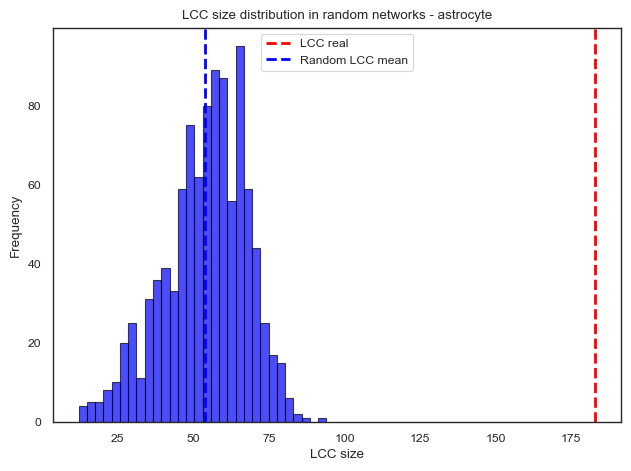

Processing cell types...:  12%|█▎        | 1/8 [18:01<2:06:12, 1081.80s/it]

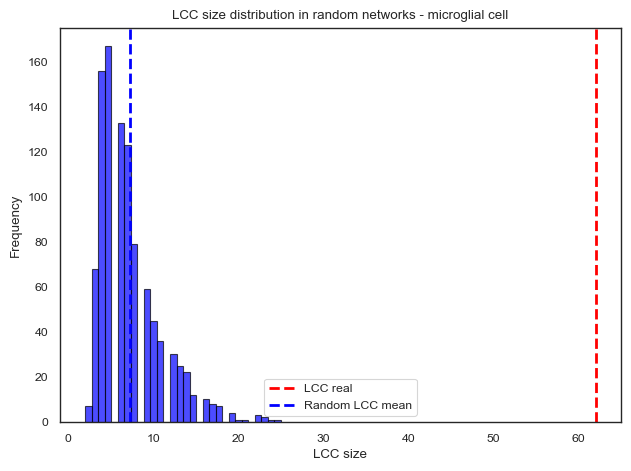

Processing cell types...:  25%|██▌       | 2/8 [23:59<1:05:34, 655.83s/it] 

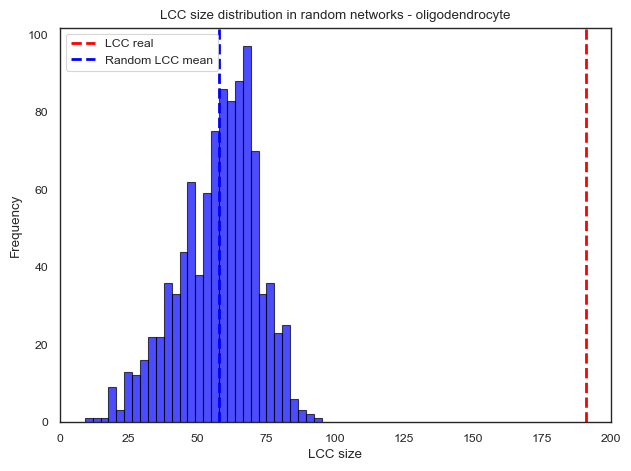

Processing cell types...:  38%|███▊      | 3/8 [43:44<1:14:47, 897.45s/it]

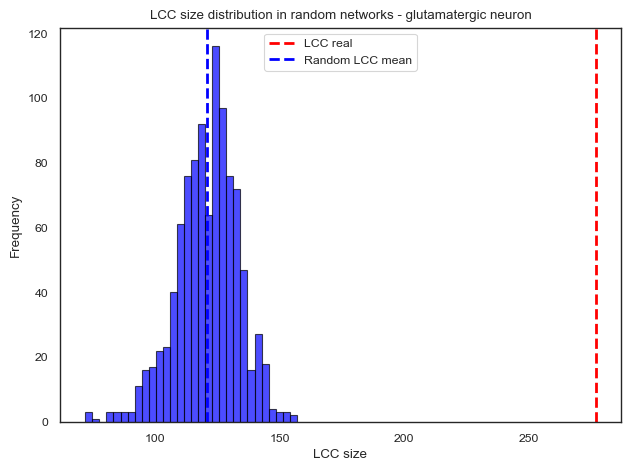

Processing cell types...:  50%|█████     | 4/8 [1:11:51<1:20:37, 1209.26s/it]

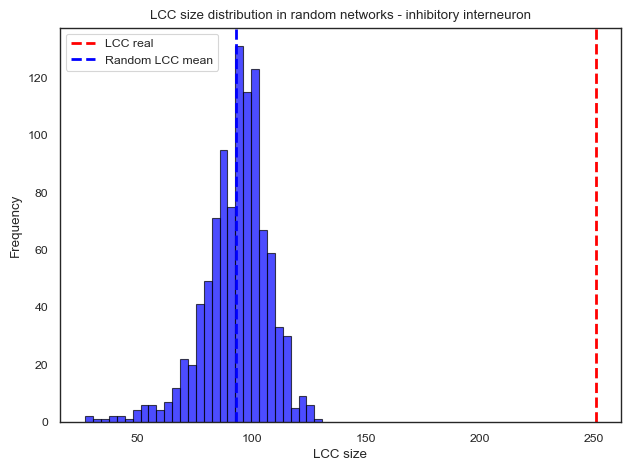

Processing cell types...:  62%|██████▎   | 5/8 [1:37:00<1:05:52, 1317.36s/it]

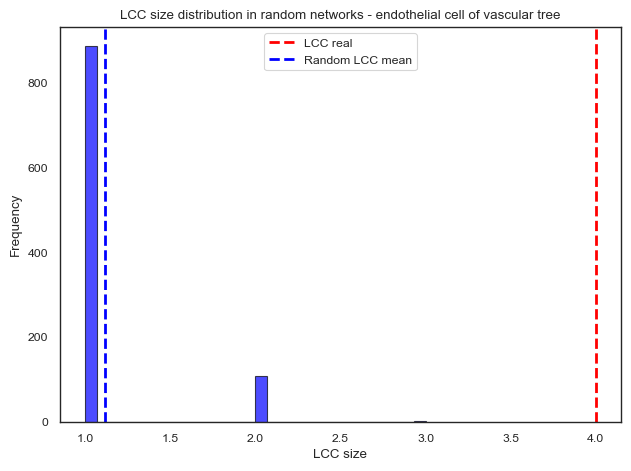

Processing cell types...:  75%|███████▌  | 6/8 [1:37:23<29:14, 877.04s/it]   

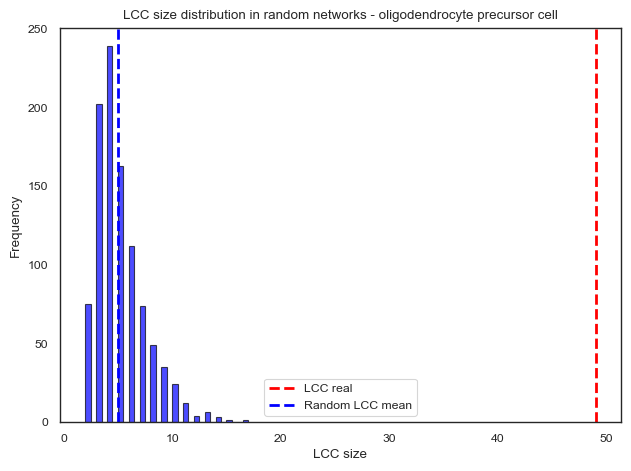

Processing cell types...:  88%|████████▊ | 7/8 [1:41:58<11:20, 680.37s/it]

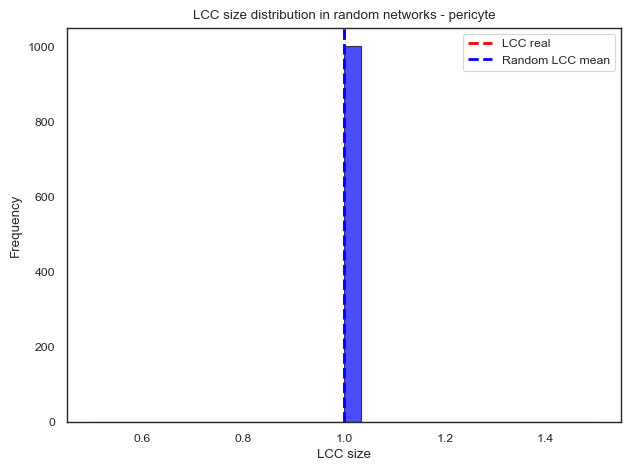

Processing cell types...: 100%|██████████| 8/8 [1:42:04<00:00, 765.58s/it]


In [243]:
table = []

for cell_type in tqdm(cell_types, desc="Processing cell types..."):

    # Overlapping DEGs in Alzheimer's module: number of DEG proteins that are in the Alzheimer's module.
    degs_cell_type = pd.read_csv(f'../data/complete/degs_{cell_type}_mapped.csv')
    degs_total = degs_cell_type.dropna(subset=['gene_id'])['gene_id']
    degs_protein = degs_cell_type.dropna(subset=['protein_id'])['protein_id']

    G = nx.read_graphml(f'../data/complete/graphs/{cell_type}_network.graphml')
    ppi_proteins = set(G.nodes())

    # Alzheimer's module proteins present in the PPI of this cell type.
    alz_in_ppi = lcc_alz.intersection(ppi_proteins)

    # Calculate the LCC of the disease network for the cell type. For this we use the DEGs found in the overall disease LCC.
    degs_cell_type_filt = pd.read_csv(f'../data/filtered/degs_{cell_type}_mapped_filt.csv')
    lcc_cell_type = functions.calculate_lcc_for_cell_type(degs_cell_type_filt['gene_id'], gen_pro, pro_pro, G_ppi)

    # Generate 1,000 random networks
    random_networks = functions.random_subset_generator(lcc_cell_type, G_ppi, 1000)

    # Calculate the size of the LCC for each random network
    random_lcc_sizes = [len(functions.calculate_lcc_from_prots(network, pro_pro, G_ppi)) for network in random_networks]

    # Calculate statistics of random modules
    random_lcc_mean = np.mean(random_lcc_sizes)
    random_lcc_std = np.std(random_lcc_sizes)

    plt.hist(random_lcc_sizes, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(len(lcc_cell_type), color='red', linestyle='dashed', linewidth=2, label="LCC real")
    plt.axvline(random_lcc_mean, color='blue', linestyle='dashed', linewidth=2, label="Random LCC mean")
    plt.xlabel("LCC size")
    plt.ylabel("Frequency")
    plt.title(f"LCC size distribution in random networks - {cell_type}")
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.savefig(f'../figures/significance/random_modules_{cell_type}.svg', format='svg', dpi=1200)
    plt.show()

    table.append([cell_type, len(degs_total), len(degs_protein), len(alz_in_ppi), len(lcc_cell_type), random_lcc_mean, random_lcc_std])

table_df = pd.DataFrame(table, columns=["Cell Type", "Total DEGs", "DEGs mapped to protein", "Cell Type proteins in main LCC", "Cell Type LCC size", "LCC mean", "LCC std"])

In [252]:
table_df['z_score'] = (table_df['Cell Type LCC size'] - table_df['LCC mean']) / table_df['LCC std']

Cell Type  Total DEGs  DEGs mapped to protein  \
0                          astrocyte        3176                    2878   
1                    microglial cell        1585                    1501   
2                    oligodendrocyte        3383                    3052   
3               glutamatergic neuron        4436                    3963   
4             inhibitory interneuron        4130                    3769   
5  endothelial cell of vascular tree         379                     367   
6     oligodendrocyte precursor cell        1963                    1832   
7                           pericyte         111                     107   

   Cell Type proteins in main LCC  Cell Type LCC size  LCC mean    LCC std  \
0                             532                 183    53.963  13.744804   
1                             334                  62     7.218   3.662032   
2                             554                 191    57.553  14.372585   
3                             733                 277   120.873  12.425573   
4                             673                 251    93.186  14.119752   
5                              73                   4     1.115   0.328291   
6                             320                  49     4.996   2.286916   
7                              20                   1     1.000   0.000000   

   p_value  adjusted_p_value    z_score  
0      0.0               0.0   9.388057  
1      0.0               0.0  14.959456  
2      0.0               0.0   9.284830  
3      0.0               0.0  12.564974  
4      0.0               0.0  11.176825  
5      0.0               0.0   8.787934  
6      0.0               0.0  19.241635  
7      1.0               1.0        NaN

In [253]:
table_df.to_csv('../data/results/cell_type_summary_stats.tsv', sep='\t', index=False)

### P-value and Adj P-value calculation

In [272]:
df = pd.read_csv('../data/results/cell_type_summary_stats.tsv', sep='\t')

In [274]:
pericyte_row = df[df['Cell Type'] == 'pericyte'].copy()

df['p_value'] = 2 * norm.sf(abs(df['z_score'])) # bilateral p-value because I take into account that the random modules can be larger or smaller than the real one.
df = df.dropna(subset=['p_value'])
df['p_value'] = pd.to_numeric(df['p_value'], errors='coerce')
df['p_value'] = df['p_value'].replace(0, np.nextafter(0, 1))
df['adj_p_value'] = multipletests(df['p_value'], method='fdr_bh')[1]

pericyte_row['adj_p_value'] = np.nan
df = pd.concat([df, pericyte_row], ignore_index=True)

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\868517119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_value'] = pd.to_numeric(df['p_value'], errors='coerce')  # Convertir a float
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\868517119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_value'] = df['p_value'].replace(0, np.nextafter(0, 1))
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\868517119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Cell Type  Total DEGs  DEGs mapped to protein  \
0                          astrocyte        3176                    2878   
1                    microglial cell        1585                    1501   
2                    oligodendrocyte        3383                    3052   
3               glutamatergic neuron        4436                    3963   
4             inhibitory interneuron        4130                    3769   
5  endothelial cell of vascular tree         379                     367   
6     oligodendrocyte precursor cell        1963                    1832   
7                           pericyte         111                     107   

   Cell Type proteins in main LCC  Cell Type LCC size  LCC mean    LCC std  \
0                             532                 183    53.963  13.744804   
1                             334                  62     7.218   3.662032   
2                             554                 191    57.553  14.372585   
3                             733                 277   120.873  12.425573   
4                             673                 251    93.186  14.119752   
5                              73                   4     1.115   0.328291   
6                             320                  49     4.996   2.286916   
7                              20                   1     1.000   0.000000   

     z_score       p_value   adj_p_value  
0   9.388057  6.111731e-21  8.556424e-21  
1  14.959456  1.351270e-50  4.729446e-50  
2   9.284830  1.619661e-20  1.889605e-20  
3  12.564974  3.289849e-36  7.676313e-36  
4  11.176825  5.295062e-29  9.266358e-29  
5   8.787934  1.523350e-18  1.523350e-18  
6  19.241635  1.658917e-82  1.161242e-81  
7        NaN           NaN           NaN

In [275]:
df.to_csv('../data/results/cell_type_summary_stats.tsv', sep='\t', index=False)

### 6.2. Representation of each cell type differential expression values

In [636]:
cell_types = ['glutamatergic neuron', 'inhibitory interneuron', 'oligodendrocyte', 'astrocyte', 'microglial cell', 'oligodendrocyte precursor cell', 'endothelial cell of vascular tree', 'pericyte']
titles = ['Glutamatergic neuron', 'Inhibitory interneuron', 'Oligodendrocyte', 'Astrocyte', 'Microglial cell', 'OPC', 'Endothelial cell', 'Pericyte']

C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


glutamatergic neuron : {'C1QA', 'HSPB1', 'GPR6', 'DRD4', 'CD14'}
inhibitory interneuron : {'PENK', 'GPR6', 'CRYZ', 'ARAP3', 'DRD4'}
oligodendrocyte : {'RELN', 'CXCR4', 'BIRC3', 'HSPA1B'}
astrocyte : {'CRYAB', 'ANXA1', 'EGR1', 'EGF', 'S100A10'}
microglial cell : {'BAG3', 'HSPA1B', 'HSPB1', 'DNAJB1'}
oligodendrocyte precursor cell : {'FOS', 'IGFBP3', 'EGR1', 'SOCS3', 'VGF'}
endothelial cell of vascular tree : {'HSPA1B', 'CACYBP', 'RBM3', 'HSPB1', 'HSPH1'}
pericyte : {'HSPA1B', 'CRYAB', 'HSPB1', 'VIM', 'HSPH1'}


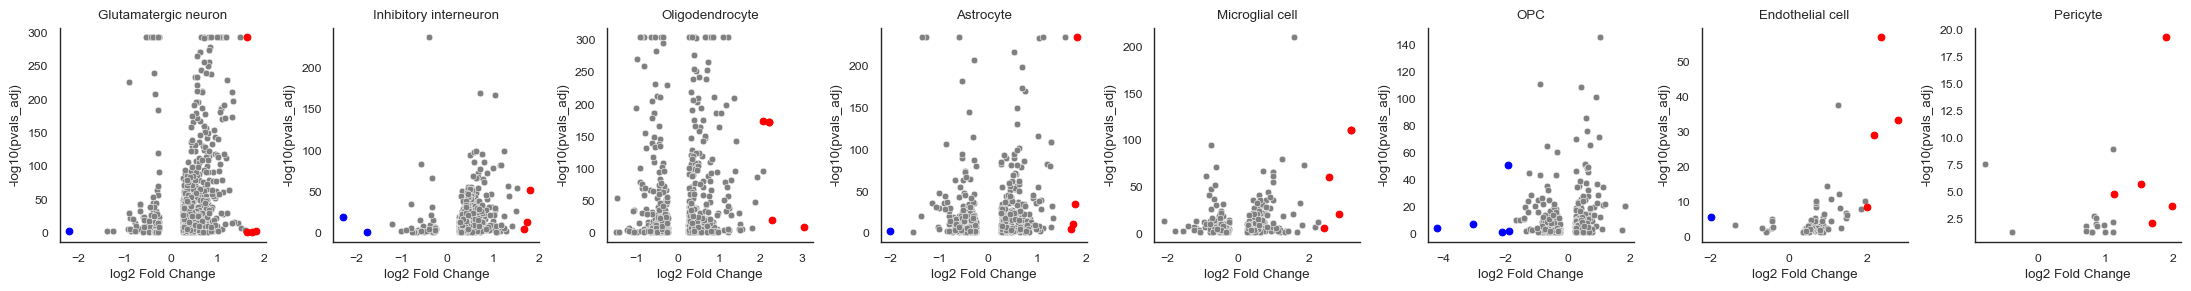

In [686]:
sns.set_context("paper")
sns.set_style("white")

fig, axes = plt.subplots(1, 8, figsize=(22,3))
axes = axes.flatten()

for i, cell_type in enumerate(cell_types):
    file_path = f"../data/filtered/degs_{cell_type}_mapped.csv"

    try:
        df = pd.read_csv(file_path)

        df["-log10(pvals_adj)"] = -np.log10(df["pvals_adj"])

        # Obtain the smallest non-zero pvals_adj greater than 0 to recalculate in case of infinity
        min_pvals_adj = df.loc[df["pvals_adj"] > 0, "pvals_adj"].min() * 0.1

        # Calculate the corrected values in case of infinity
        df.loc[np.isinf(df["-log10(pvals_adj)"]), "-log10(pvals_adj)"] = -np.log10(min_pvals_adj)

        top_genes = df.loc[df["logfoldchanges"].abs().nlargest(5).index]

        top_genes.loc[top_genes.index, "color"] = top_genes.loc[top_genes.index, "logfoldchanges"].apply(
            lambda x: "red" if x > 0 else "blue"
        )

        print(cell_type, ":", set(top_genes["gene_symbol"]))

        sns.scatterplot(data=df, y="-log10(pvals_adj)", x="logfoldchanges", color='grey', legend=False, ax=axes[i])

        for _, row in top_genes.iterrows():
            axes[i].scatter(row["logfoldchanges"], row["-log10(pvals_adj)"], color=row['color'])

        axes[i].set_ylabel("-log10(pvals_adj)")
        axes[i].set_xlabel("log2 Fold Change")
        axes[i].set_title(f"{titles[i]}")

    except FileNotFoundError:
        axes[i].set_title(f"No data for {cell_type}")
        axes[i].axis("off")

plt.tight_layout()
sns.despine()
plt.savefig('../figures/volcano_per_type_notext.svg', format = 'svg', dpi=1200)
plt.show()

### 6.3. Representation of top 20 most up- and down-regulated DEGs and DEGs expressed in all cell types

In [60]:
gen_pro = pd.read_csv('../data/disnet/gen_pro.tsv', sep='\t')
gen = pd.read_csv("../data/disnet/gen.tsv", sep="\t")

In [ ]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron',
              'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

#### Heatmap 1

In [ ]:
file_pattern = '../data/filtered/degs_*_mapped.csv'

files = glob.glob(file_pattern)

In [ ]:
dfs = []

for file in files:
    df = pd.read_csv(file)

    df_filtered = df[['protein_id', 'gene_symbol', 'logfoldchanges']]

    cell_type = file.split('/')[-1].split('_')[1]
    df_filtered['cell_type'] = cell_type
    dfs.append(df_filtered)

lfc_df = pd.concat(dfs, ignore_index=True)
print(lfc_df)

In [445]:
top_high = lfc_df.sort_values(by="logfoldchanges", ascending=False)["protein_id"].drop_duplicates().head(20)
top_low = lfc_df.sort_values(by="logfoldchanges", ascending=True)["protein_id"].drop_duplicates().head(20)
top_proteins = pd.concat([top_high, top_low])

lfc_filtered = lfc_df[lfc_df["protein_id"].isin(top_proteins)]

lfc_filtered["max_abs_LFC"] = lfc_filtered["logfoldchanges"].abs()
lfc_filtered['cell_type'] = lfc_filtered["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\1253390478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfc_filtered["max_abs_LFC"] = lfc_filtered["logfoldchanges"].abs()
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\1253390478.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfc_filtered['cell_type'] = lfc_filtered["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")


protein_id gene_symbol  logfoldchanges        cell_type  max_abs_LFC
14       P43490       NAMPT       -0.900505        astrocyte     0.900505
22       P06703      S100A6        1.067540        astrocyte     1.067540
50       Q2I0M5       RSPO4       -1.032063        astrocyte     1.032063
118      O60603        TLR2       -1.532612        astrocyte     1.532612
133      P17275        JUNB       -0.300338        astrocyte     0.300338
...         ...         ...             ...              ...          ...
3194     P04792       HSPB1        2.069515  oligodendrocyte     2.069515
3223     P04792       HSPB1        1.884719         pericyte     1.884719
3227     Q92598       HSPH1        1.676103         pericyte     1.676103
3230     P0DMV8      HSPA1B        1.975146         pericyte     1.975146
3232     P02511       CRYAB        1.525713         pericyte     1.525713

[123 rows x 5 columns]

#### Heatmap 2

In [ ]:
cell_networks = {cell: nx.read_graphml(f"../data/filtered/graphs/{cell}_network.graphml") for cell in
                 cell_types}

In [ ]:
combined_degs = [
    {"protein_id": node, "gene_symbol": G.nodes[node]['gene_symbol'], "gene_id": G.nodes[node]['gene_id'],
     "cell_type": cell_type, "logfoldchanges": G.nodes[node]['logfoldchanges']}
    for cell_type, G in cell_networks.items()
    for node in G.nodes()
    if "logfoldchanges" in G.nodes[node]
]

df = pd.DataFrame(combined_degs)

In [ ]:
count_cells = df.groupby("protein_id")["cell_type"].nunique().reset_index()
count_cells.columns = ["protein_id", "num_cell_types"]

In [448]:
df2 = df.merge(count_cells, on="protein_id")
df2['cell_type'] = df2["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")

protein_id gene_symbol   gene_id  cell_type  logfoldchanges  \
0        P04626       ERBB2    2064.0  astrocyte       -0.287940   
1        Q14517        FAT1    2195.0  astrocyte        0.343325   
2        Q8TCT8      SPPL2A   84888.0  astrocyte       -0.353458   
3        O60290      ZNF862  643641.0  astrocyte        0.419059   
4        P35613         BSG     682.0  astrocyte       -0.386828   
...         ...         ...       ...        ...             ...   
3234     P60484        PTEN    5728.0   pericyte       -0.782102   
3235     P17676       CEBPB    1051.0   pericyte        1.105564   
3236     P49716       CEBPD    1052.0   pericyte        0.708934   
3237     Q09666       AHNAK   79026.0   pericyte        0.989039   
3238     Q7Z6G8      ANKS1B   56899.0   pericyte        0.978241   

      num_cell_types  
0                  1  
1                  2  
2                  1  
3                  4  
4                  3  
...              ...  
3234               2  
3235               4  
3236               5  
3237               3  
3238               4  

[3239 rows x 6 columns]

#### Representation

In [671]:
titles = ['Glutamatergic neuron', 'Inhibitory interneuron', 'Oligodendrocyte', 'Astrocyte', 'Microglial cell', 'OPC', 'Endothelial cell', 'Pericyte']

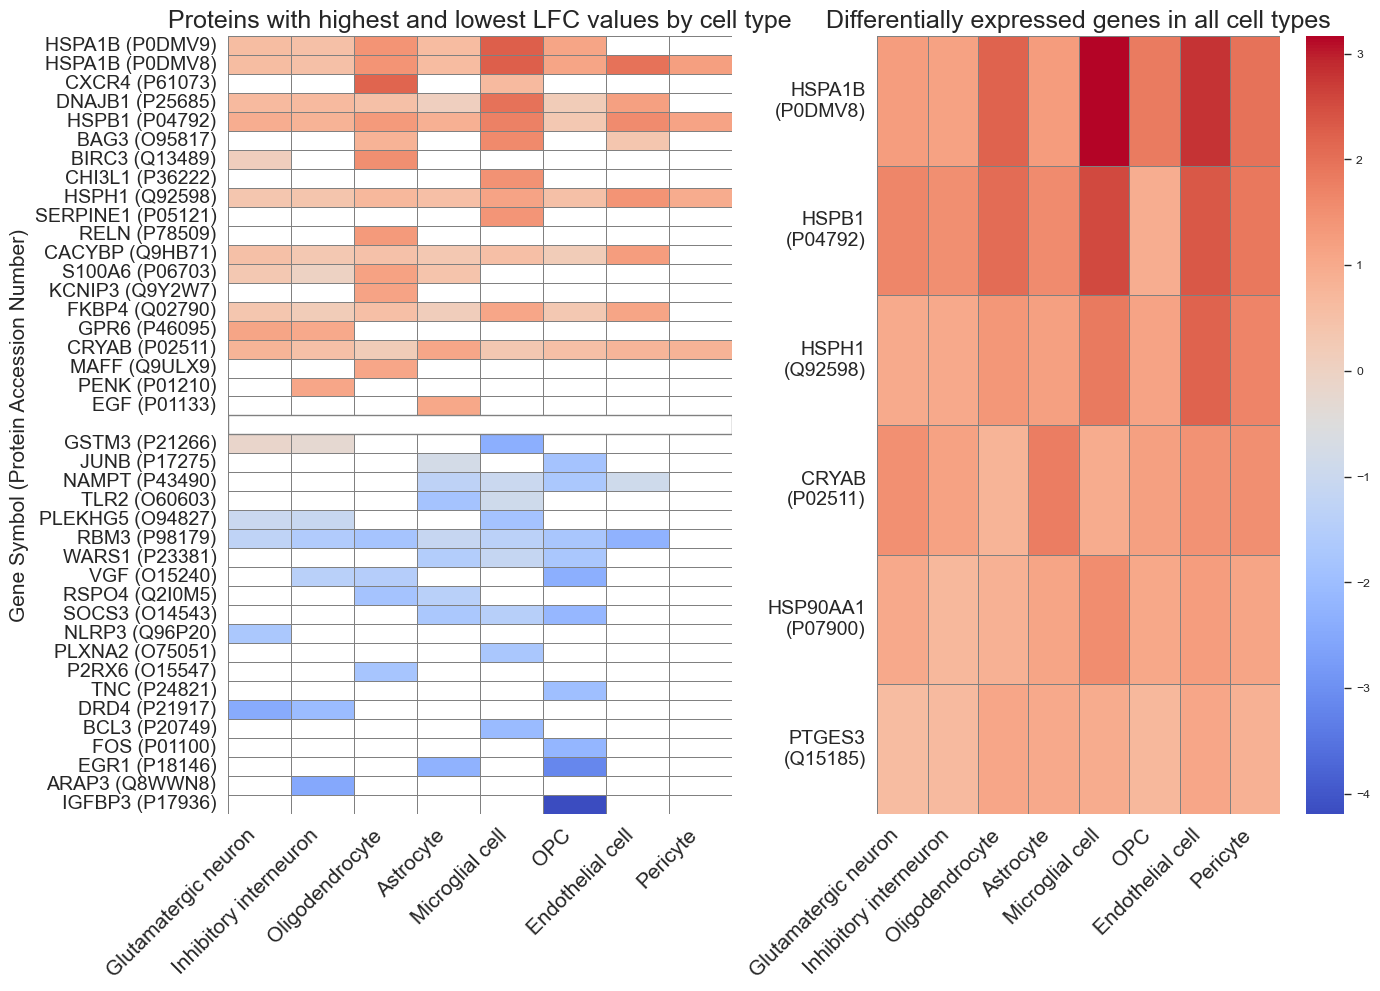

In [680]:
heatmap_df = lfc_filtered.pivot(index="protein_id", columns="cell_type", values="logfoldchanges")

# Annotate gene_symbol
gene_symbols = lfc_filtered.set_index("protein_id")["gene_symbol"].to_dict()
heatmap_df.index = [f"{gene_symbols.get(x, x)} ({x})" for x in heatmap_df.index]

heatmap_df["max_lfc"] = heatmap_df.max(axis=1)
heatmap_df = heatmap_df.sort_values(by="max_lfc", ascending=False).drop(columns=["max_lfc"])

# Blank space between up- and down-regulated genes
half = len(heatmap_df) // 2
gap = pd.DataFrame(np.nan, index=[""], columns=heatmap_df.columns)
heatmap_df = pd.concat([heatmap_df.iloc[:half], gap, heatmap_df.iloc[half:]])

# ===============================================================================

df_filtered_proteins = df2[df2["num_cell_types"] == 8]
gene_symbol_mapping = df_filtered_proteins.set_index("protein_id")["gene_symbol"].drop_duplicates()
df_pivot = df_filtered_proteins.pivot_table(index="protein_id", columns="cell_type", values="logfoldchanges")

# Annotate gene_symbol
df_pivot.index = [f"{gene_symbol_mapping.get(x, x)}\n({x})" for x in df_pivot.index]

df_pivot["max_lfc"] = df_pivot.max(axis=1)
df_pivot = df_pivot.sort_values(by="max_lfc", ascending=False).drop(columns=["max_lfc"])

# Define column order
order = ['glutamatergic neuron', 'inhibitory interneuron', 'oligodendrocyte', 'astrocyte', 'microglial cell', 'oligodendrocyte precursor cell', 'endothelial cell', 'pericyte']

heatmap_df = heatmap_df[order]
df_pivot = df_pivot[order]

# Define shared color palette
vmin = min(heatmap_df.min().min(), df_pivot.min().min())
vmax = max(heatmap_df.max().max(), df_pivot.max().max())

# ===============================================================================

sns.set_context("paper")
sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(14, 10), gridspec_kw={'width_ratios': [1, 1]})

# Heatmap 1
sns.heatmap(
    heatmap_df, cmap="coolwarm", center=0, linewidths=0.5, linecolor="grey",
    vmin=vmin, vmax=vmax, annot=False, ax=axes[0], cbar=False
)
axes[0].add_patch(Rectangle((0, 20), 8, 1, fill=True, facecolor= 'white', edgecolor='gray', lw=1))
axes[0].set_title("Proteins with highest and lowest LFC values by cell type", fontsize=18)
axes[0].set_xlabel("")
axes[0].set_ylabel("Gene Symbol (Protein Accession Number)", fontsize=15)
axes[0].set_xticklabels(titles, rotation=45, ha='right', fontsize=15)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=14)

# Heatmap 2
sns.heatmap(
    df_pivot, cmap="coolwarm", linewidths=0.5, linecolor='grey',
    vmin=vmin, vmax=vmax, annot=False, ax=axes[1]
)
axes[1].set_title("Differentially expressed genes in all cell types", fontsize=18)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_xticklabels(titles, rotation=45, ha='right', fontsize=15)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation = 0, fontsize=14)

plt.tight_layout()
# plt.savefig('../figures/combined_heatmaps.pdf', format='pdf', dpi=1200)
plt.savefig('../figures/combined_heatmaps_pdf.svg', format='svg', dpi=1200)
plt.show()


## 8. Network metrics analysis

Calculation of degrees, betweenness and closeness centralities and clustering coefficient for each of the cell type-specific DEGs inside the main interactome.

Considering the entire PPI, I want to know how the cell type-specific DEGs are located within the interactome. For the DEGs in each cell type, I draw the metrics (from the subnetworks I only need the genes that are in them) and plot the distributions that follow these metrics, comparing them with the distribution that the Alzheimer's module follows.

### 8.1. Alzheimer module calculation

In [ ]:
dis_gen = pd.read_csv('../data/disnet/dis_gen.tsv', sep='\t')
gen_pro = pd.read_csv('../data/disnet/gen_pro.tsv', sep='\t')
pro_pro = pd.read_csv('../data/disnet/pro_pro.tsv', sep='\t')

In [ ]:
G_ppi = nx.from_pandas_edgelist(pro_pro, 'prA', 'prB')

In [ ]:
def get_disease_module(disease, dis_gen, gen_pro, pro_pro, PPI):
    genes = functions.genes_dis(disease, dis_gen)
    prots = functions.pro_gen_dict(genes, gen_pro)
    prots_interactome = functions.gen_pro_PPI(prots, pro_pro)
    SG = PPI.subgraph(prots_interactome)
    lcc = functions.lcc(SG)

    return lcc

In [ ]:
lcc_alz = get_disease_module('C0002395', dis_gen, gen_pro, pro_pro, G_ppi)
len(lcc_alz)

### 8.2. Metrics calculation for all the nodes in the interactome

In [605]:
def calculate_metrics(graph):
    """
    Calculates network metrics at node level. Returns a DataFrame with the metrics.
    """
    # Betweenness centrality
    betweenness = nx.betweenness_centrality(graph)

    # Closeness centrality
    closeness = nx.closeness_centrality(graph)

    # Clustering coefficient
    clustering = nx.clustering(graph)

    # Identificar hubs (proteínas con mayor grado)
    degree = dict(graph.degree())
    degree_values = list(degree.values())
    percentile_90 = np.percentile(degree_values, 90)
    is_hub = {node: degree[node] >= percentile_90 for node in degree}

    return betweenness, closeness, clustering, degree, is_hub

In [ ]:
# Metrics calculation for all proteins in the PPI
betweenness, closeness, clustering, degree, is_hub = calculate_metrics(G_ppi)

In [ ]:
# Convert metrics of whole interactome to a dataframe
df = pd.DataFrame({
    'protein_id': list(degree.keys()),
    'degree': list(degree.values()),
    'betweenness_centrality': list(betweenness.values()),
    'closeness_centrality': list(closeness.values()),
    'is_hub': list(is_hub.values())
})

In [ ]:
df['is_in_LCC'] = df['protein_id'].isin(lcc_alz)

In [ ]:
df.to_csv('../data/results/G_ppi_analysis.csv', index = False)

### 8.3. Metrics calculation for the DEGs nodes for each cell type

In [ ]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [ ]:
results_list = []

for cell_type in tqdm(cell_types, desc="Processing cell types..."):

    graph = nx.read_graphml(f'../data/filtered/graphs/{cell_type}_network.graphml')

    ppi_proteins = set(graph.nodes())
    print(ppi_proteins)

    # Añadir las métricas al DataFrame
    for protein in ppi_proteins:
        protein_id = protein
        gene_id = graph.nodes[protein].get("gene_id", "NA")
        gene_symbol = graph.nodes[protein].get("gene_symbol", "NA")
        logfoldchanges = graph.nodes[protein].get("logfoldchanges", "NA")
        pvals = graph.nodes[protein].get("pval", "NA")
        pvals_adj = graph.nodes[protein].get("pval_adj", "NA")

        # Obtener las métricas para la proteína
        betweenness_val = betweenness.get(protein_id, None)
        closeness_val = closeness.get(protein_id, None)
        clustering_val = clustering.get(protein_id, None)
        degree_val = degree.get(protein_id, None)
        is_hub_val = is_hub.get(protein_id, False)

        # Añadir la fila al DataFrame de resultados
        result_row = {
            "protein_id": protein_id,
            "gene_id": gene_id,
            "gene_symbol": gene_symbol,
            "cell_type": cell_type,
            "logfoldchanges": logfoldchanges,
            "pvals": pvals,
            "pvals_adj": pvals_adj,
            "degree": degree_val,
            "betweenness_centrality": betweenness_val,
            "closeness_centrality": closeness_val,
            "clustering_coefficient": clustering_val,
            "is_hub": is_hub_val
        }

        results_list.append(result_row)

results_df = pd.DataFrame(results_list)

results_df.to_csv('../data/results/network_analysis.csv', index=False)

### 8.4. Analysis of the metrics distributions across cell types

In [386]:
cell_data = pd.read_csv('../data/results/network_analysis.csv')
module_data = pd.read_csv('../data/results/G_ppi_analysis.csv')

module_data_lcc = module_data[module_data['is_in_LCC'] == True]

In [575]:
module_data_lcc["dataset"] = "General module for AD"
cell_data["dataset"] = cell_data["cell_type"]

combined_data = pd.concat([module_data_lcc, cell_data])
combined_data

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\602881201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  module_data_lcc["dataset"] = "General module for AD"


protein_id  degree  betweenness_centrality  closeness_centrality  \
0     A0A087WXM9       8                0.000003              0.305735   
2         P05783      91                0.000429              0.367223   
4         P08670     266                0.003726              0.398942   
6         P53350     221                0.001902              0.381054   
32        Q96CV9      92                0.000621              0.362136   
...          ...     ...                     ...                   ...   
3234      P17676      27                0.000056              0.346096   
3235      P07900     237                0.001698              0.398471   
3236      P13693     124                0.000313              0.374662   
3237      P0DMV8      63                0.000533              0.359315   
3238      P08238     553                0.013363              0.420794   

      is_hub is_in_LCC                dataset  gene_id gene_symbol cell_type  \
0      False      True  General module for AD      NaN         NaN       NaN   
2       True      True  General module for AD      NaN         NaN       NaN   
4       True      True  General module for AD      NaN         NaN       NaN   
6       True      True  General module for AD      NaN         NaN       NaN   
32      True      True  General module for AD      NaN         NaN       NaN   
...      ...       ...                    ...      ...         ...       ...   
3234   False       NaN               pericyte   1051.0       CEBPB  pericyte   
3235    True       NaN               pericyte   3320.0    HSP90AA1  pericyte   
3236    True       NaN               pericyte   7178.0        TPT1  pericyte   
3237   False       NaN               pericyte   3304.0      HSPA1B  pericyte   
3238    True       NaN               pericyte   3326.0    HSP90AB1  pericyte   

      logfoldchanges         pvals     pvals_adj  clustering_coefficient  
0                NaN           NaN           NaN                     NaN  
2                NaN           NaN           NaN                     NaN  
4                NaN           NaN           NaN                     NaN  
6                NaN           NaN           NaN                     NaN  
32               NaN           NaN           NaN                     NaN  
...              ...           ...           ...                     ...  
3234        1.105564  9.147368e-06  5.491340e-03                0.150000  
3235        1.110109  2.761193e-13  1.112958e-09                0.061975  
3236        0.802365  1.618387e-04  4.390652e-02                0.056517  
3237        1.975146  1.293792e-07  1.738302e-04                0.045059  
3238        0.861556  2.566908e-06  2.336300e-03                0.020023  

[5936 rows x 14 columns]

In [655]:
titles = ['General module for AD', 'Glutamatergic neuron', 'Inhibitory interneuron', 'Oligodendrocyte', 'Astrocyte', 'Microglial cell', 'OPC', 'Endothelial cell', 'Pericyte']

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\2142562447.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset_sizes = combined_data.groupby("dataset")["protein_id"].nunique()
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\2142562447.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x="dataset", y="degree", ax=ax, palette=palette, order=ordered_datasets,dodge=False)
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\2142562447.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{titles[i]}\nn = {subset_sizes

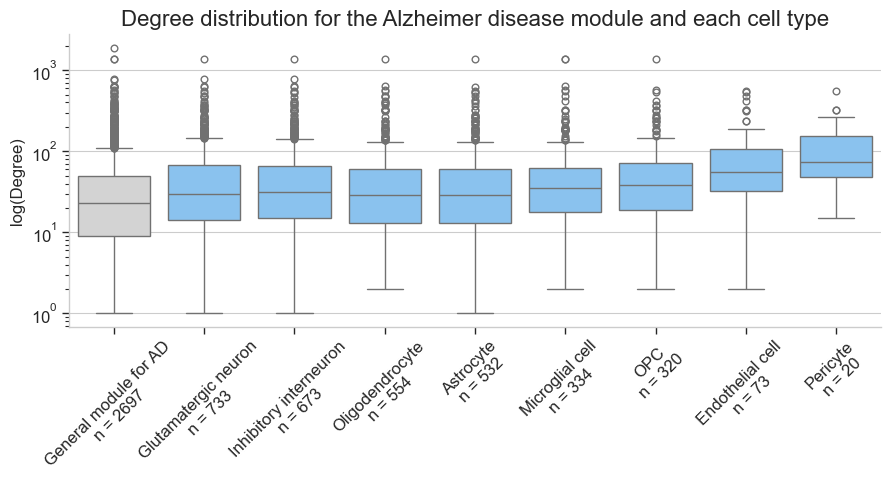

In [658]:
# Subset sizes calculation
subset_sizes = combined_data.groupby("dataset")["protein_id"].nunique()

# Color palette
ordered_datasets = subset_sizes.sort_values(ascending=False).index
combined_data["dataset"] = pd.Categorical(combined_data["dataset"], categories=ordered_datasets, ordered=True)
palette = {dataset: '#79C4FF' for dataset in ordered_datasets}

# Assign light grey to general module for AD
palette["General module for AD"] = "#D3D3D3"

fig, ax = plt.subplots(figsize=(9, 5))

sns.set_context("paper")
sns.set_style("whitegrid")

sns.boxplot(data=combined_data, x="dataset", y="degree", ax=ax, palette=palette, order=ordered_datasets,dodge=False)

ax.tick_params(axis='both', which='both', bottom=True, left=True)

plt.title('Degree distribution for the Alzheimer disease module and each cell type', fontsize=16)
plt.xlabel('')
ax.set_xticklabels([f"{titles[i]}\nn = {subset_sizes[dataset]}" for i, dataset in enumerate(ordered_datasets)],
                   rotation=45, ha="center", fontsize=12)

plt.yticks(fontsize=12)
plt.yscale('log')
plt.ylabel('log(Degree)', fontsize=12)
sns.despine()
plt.tight_layout()
# plt.savefig('../figures/degree_boxplot.pdf', format='pdf', dpi=1200)
plt.savefig('../figures/degree_boxplot.svg', format='svg', dpi=1200)
plt.show()

### 8.5. Network metrics analysis


In [659]:
cell_data = pd.read_csv('../data/results/network_analysis.csv')

In [668]:
cols_of_interest = ["degree"]

stats = cell_data.groupby("cell_type")["degree"].agg(["mean", "std", "median", "min", "max"])
stats["count"] = cell_data.groupby("cell_type").size()

print(stats)

                                         mean         std  median  min   max  \
cell_type                                                                      
astrocyte                           57.486842   97.024051    29.0    1  1379   
endothelial cell of vascular tree   98.767123  119.863872    55.0    2   553   
glutamatergic neuron                61.219645   98.005476    30.0    1  1379   
inhibitory interneuron              61.210996   99.727546    31.0    1  1381   
microglial cell                     66.434132  129.637865    35.5    2  1381   
oligodendrocyte                     56.301444   97.276815    29.0    2  1379   
oligodendrocyte precursor cell      65.284375  105.131312    38.0    2  1379   
pericyte                           132.300000  138.173080    74.0   15   553   

                                   count  
cell_type                                 
astrocyte                            532  
endothelial cell of vascular tree     73  
glutamatergic neuron       

In [669]:
module_data = pd.read_csv('../data/results/G_ppi_analysis.csv')

module_data_lcc = module_data[module_data['is_in_LCC'] == True]
stats = module_data_lcc["degree"].agg(["mean", "std", "median", "min", "max", "count"])

print(stats)

mean        45.292918
std         84.963373
median      23.000000
min          1.000000
max       1901.000000
count     2697.000000
Name: degree, dtype: float64


In [704]:
gene_info = []

for type, gene in top_genes.items():
    for g in gene:
        gene_info.append(g)

print(gene_info)

['C1QA', 'HSPB1', 'GPR6', 'DRD4', 'CD14', 'PENK', 'GPR6', 'CRYZ', 'ARAP3', 'DRD4', 'RELN', 'CXCR4', 'BIRC3', 'HSPA1B', 'CRYAB', 'ANXA1', 'EGR1', 'EGF', 'S100A10', 'BAG3', 'HSPA1B', 'HSPB1', 'DNAJB1', 'FOS', 'IGFBP3', 'EGR1', 'SOCS3', 'VGF', 'HSPA1B', 'CACYBP', 'RBM3', 'HSPB1', 'HSPH1', 'HSPA1B', 'CRYAB', 'HSPB1', 'VIM', 'HSPH1']


In [710]:
top_genes.sort_values('degree')[['gene_symbol', 'degree']].drop_duplicates()

gene_symbol  degree
30        RELN       2
56        GPR6       2
32         VGF       3
58       ARAP3       4
59        DRD4       5
62        PENK       8
5          EGF       9
35        CRYZ      11
25        C1QA      19
81      IGFBP3      21
49        CD14      24
6         EGR1      25
39      HSPA1B      31
9         RBM3      35
27       CXCR4      37
42       BIRC3      41
1      S100A10      43
89       SOCS3      47
0        HSPH1      48
65       CRYAB      49
46      DNAJB1      51
11      HSPA1B      63
51       ANXA1      80
45      CACYBP     104
75        BAG3     118
80         FOS     140
57         VIM     266
26       HSPB1     320

### 8.5. Gephi file preparation

Quiero tener un archivo con la red representada por aquellos genes que están en el LCC del Alzheimer y además en al menos un tipo celular.

In [333]:
pro_pro = pd.read_csv("../data/disnet/pro_pro.tsv", sep='\t')

cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron',
              'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [334]:
filtered_files = glob.glob("../data/filtered/degs_*_mapped.csv")

filtered_data = functions.load_and_process(filtered_files)

In [335]:
unique_proteins = filtered_data['protein_id'].unique()

In [339]:
G = nx.Graph()

G.add_nodes_from(unique_proteins)

In [340]:
print(G)

Graph with 1519 nodes and 0 edges


In [341]:
for _, row in pro_pro.iterrows():
    protein_A = row['prA']
    protein_B = row['prB']

    if protein_A in unique_proteins and protein_B in unique_proteins:
        # Avoid self-interactions
        if protein_A != protein_B:
            G.add_edge(protein_A, protein_B)

print(G)

Graph with 1519 nodes and 8331 edges


In [343]:
for _, row in filtered_data.iterrows():
    protein_id = row['protein_id']

    if protein_id in G.nodes:
        G.nodes[protein_id]['gene_id'] = row['gene_id']
        G.nodes[protein_id]['gene_symbol'] = row['gene_symbol']

print(G)

nx.write_graphml(G, "../data/filtered/graphs/gephi/proteins_network.graphml")

Graph with 1519 nodes and 8331 edges
